In [46]:
import cv2

In [47]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

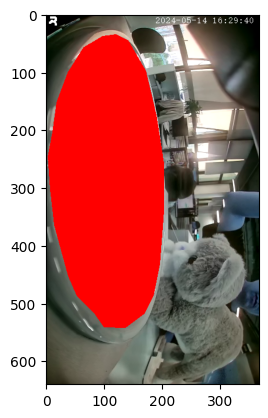

(640, 368, 3)


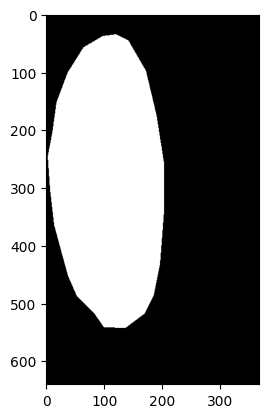

In [48]:
primary_mask = cv2.imread("primary_mask.png")

primary_mask = cv2.cvtColor(primary_mask, cv2.COLOR_BGR2RGB)
plt.imshow(primary_mask)
plt.show()
print(primary_mask.shape)
for i in range(primary_mask.shape[0]):
    for j in range(primary_mask.shape[1]):
        if primary_mask[i,j,0] >= 230 and primary_mask[i,j,1] <= 20 and primary_mask[i,j,2] <= 20:
            primary_mask[i,j,0] = 255
            primary_mask[i,j,1] = 255
            primary_mask[i,j,2] = 255
            continue
        else:
            primary_mask[i,j,0] = 0
            primary_mask[i,j,1] = 0
            primary_mask[i,j,2] = 0
plt.imshow(primary_mask)
plt.show()
primary_mask = primary_mask.astype(np.uint8)

In [54]:
video_path = r'AI数据样本\瓷碗出粮（3种粮）+碗内余粮+积粮\1715675377828.mp4'
capture = cv2.VideoCapture(video_path)

count = 0
frame1, frame2 = None, None
while True:
    ret, frame = capture.read()
    count += 1
    if not ret:
        break
    if count == 100:
        frame1 = frame
        # 使用primary_mask进行抠图
        frame1 = cv2.bitwise_and(frame1, frame1, mask=primary_mask[:,:,0])
    if count == 3000:
        frame2 = frame
        frame2 = cv2.bitwise_and(frame2, frame2, mask=primary_mask[:,:,0])
    elif count >= 5000:
        break
# frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)
capture.release()
temp = None

C:\Users\dyj39\AppData\Local\Temp\ipykernel_28824\886829579.py:26: RuntimeWarning: Mean of empty slice.
  new_centers = np.array([data[labels == k].mean(axis=0) for k in range(K)])
e:\anaconda\envs\feetcat\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


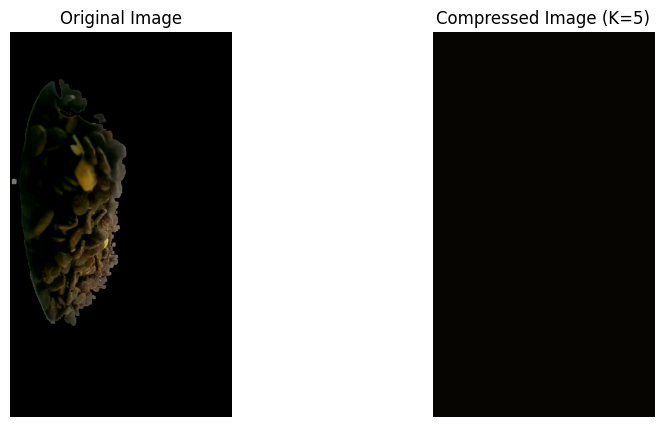

In [56]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def kmeans_rgb(image, K, max_iters=100, tol=1e-4):
    """
    针对三通道图片（RGB）的 K-Means 实现
    :param image: 输入的三通道图片，形状为 (H, W, 3)
    :param K: 簇的数量（颜色的数量）
    :param max_iters: 最大迭代次数
    :param tol: 中心点变化的容忍度，用于提前停止
    :return: labels, centers
    """
    H, W, C = image.shape
    data = image.reshape(-1, C).astype(np.float32)  # 将图像转换为 (H*W, 3) 的二维数组

    # 1. 随机初始化中心点
    centers = data[np.random.choice(data.shape[0], K, replace=False)]

    for _ in range(max_iters):
        # 2. 分配数据点到最近的簇
        distances = np.linalg.norm(data[:, np.newaxis] - centers, axis=2)  # 计算每个点到每个中心的距离
        labels = np.argmin(distances, axis=1)  # 找到最近的簇

        # 3. 更新簇中心
        new_centers = np.array([data[labels == k].mean(axis=0) for k in range(K)])

        # 4. 检查是否收敛
        if np.linalg.norm(new_centers - centers) < tol:
            break

        centers = new_centers

    return labels, centers

# 读取图片
image = cv2.imread('primary_mask.png')  # 替换为你的图片路径
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 转换为 RGB 格式
image = temp
# 调用自定义 K-Means
K = 5  # 聚类的颜色数量
labels, centers = kmeans_rgb(image, K)

# 将图片的像素替换为聚类中心颜色
compressed_image = centers[labels].reshape(image.shape).astype(np.uint8)

# 显示原始图片和聚类后的图片
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(compressed_image)
plt.title(f'Compressed Image (K={K})')
plt.axis('off')

plt.show()

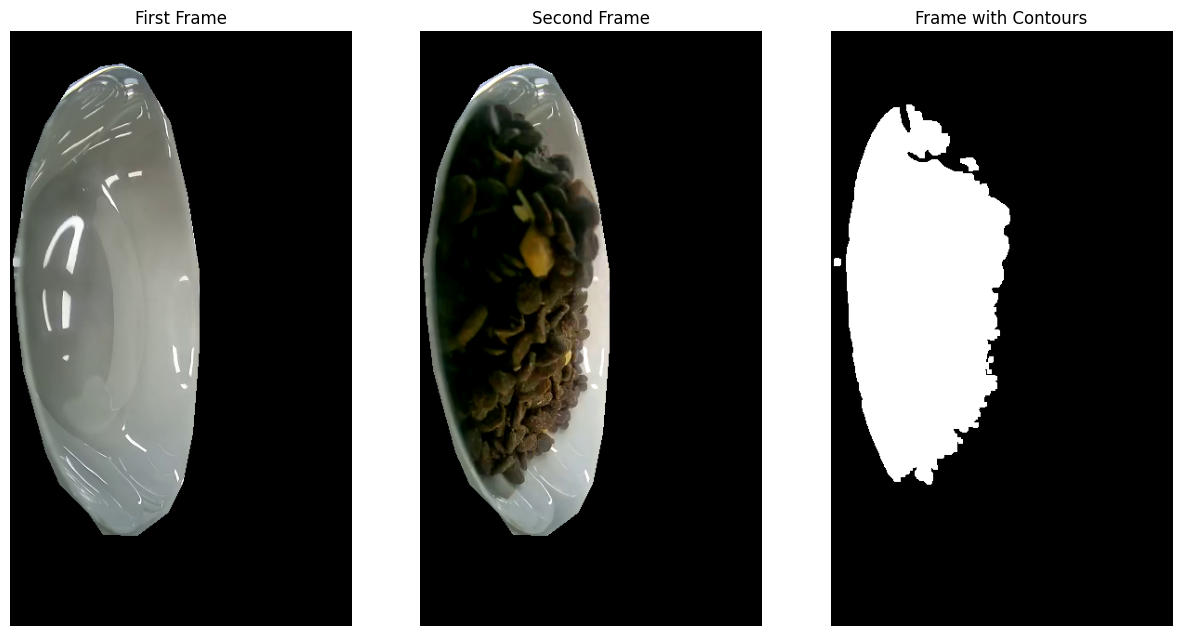

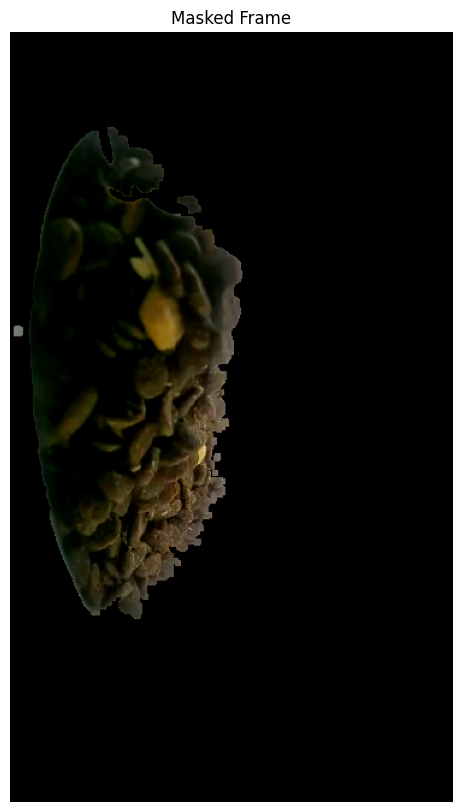

ret: 22268563.821671247
label: 2 (235520, 1)
center: [[4.3838924e+01 3.9191185e+01 1.4253561e+01]
 [5.1621646e-01 8.5524946e-01 4.8945043e-02]
 [9.6883698e+01 8.2060287e+01 5.2707893e+01]]
colors: [(43, 39, 14), (0, 0, 0), (96, 82, 52)]
pet_food_colors: [(43, 39, 14), (96, 82, 52)]
label: (235520, 1) [[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]


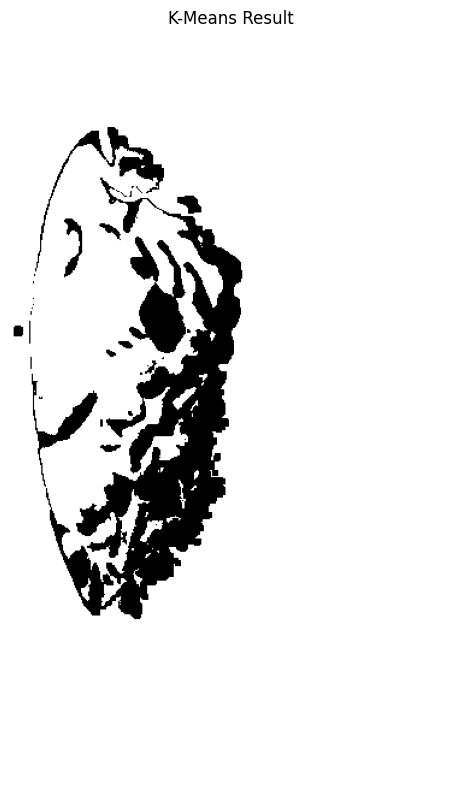

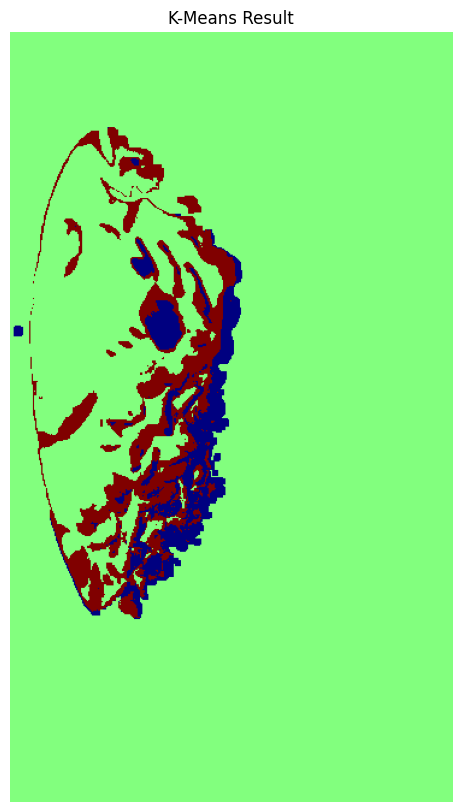

In [55]:

def diff_image(f1, f2):
    global temp
    frame1 = cv2.cvtColor(f1.copy(), cv2.COLOR_BGR2GRAY)
    frame2 = cv2.cvtColor(f2.copy(), cv2.COLOR_BGR2GRAY)
    
    frame3 = cv2.absdiff(frame1, frame2)

    _, thresh = cv2.threshold(frame3, 60, 255, cv2.THRESH_BINARY)

    # 可选：应用形态学操作以减少噪声
    kernel = np.ones((5, 5), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    # 查找轮廓
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 找到最大连通域
    # 找前十个最大连通域
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

    # 将前十个连通域转换成mask
    mask = np.zeros(frame1.shape, np.uint8)
    for contour in contours:
        cv2.drawContours(mask, [contour], 0, 255, -1)
    # max_contour = max(contours, key=cv2.contourArea)

    # # 将最大连通域转换程mask
    # mask = np.zeros(frame1.shape, np.uint8)
    # cv2.drawContours(mask, [max_contour], 0, 255, -1)

    # 显示原始帧和带有轮廓的帧
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 3, 1)
    plt.title('First Frame')
    plt.imshow(f1)
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(f2)
    plt.axis('off')
    plt.title('Second Frame')
    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.title('Frame with Contours')
    plt.show()


    # 使用mask将第二帧抠出来
    masked_frame = cv2.bitwise_and(f2, f2, mask=mask)
    temp = masked_frame.copy()

    # 显示抠出来的帧
    plt.figure(figsize=(10, 10))
    plt.imshow(masked_frame)
    plt.axis('off')
    plt.title('Masked Frame')
    plt.show()

    # # 使用kmeans算法聚类, 忽略0的像素值
    # masked_frame[masked_frame == 0] = 255
    # plt.imshow(masked_frame)
    # plt.title('masked_frame')
    # plt.show()

    Z = masked_frame.reshape((-1, 3))
    Z = np.float32(Z)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 3
    ret, label, center = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    # label, center = kmeans_rgb(masked_frame, 3)
    # 解释kmeans的输出
    print('ret:', ret)
    print('label:', np.max(label), label.shape)
    print('center:', center)

    # 打印center的颜色
    colors = []
    for i in range(K):
        colors.append((int(center[i][0]), int(center[i][1]), int(center[i][2])))
    print('colors:', colors)

    # 挑选Blue通道是三个通道中最小的颜色
    pet_food_colors = []
    for color in colors:
        if color[2] < color[0] and color[2] < color[1]:
            pet_food_colors.append(color)
    print('pet_food_colors:', pet_food_colors)

    # 显示每个像素的聚类结果
    print('label:', label.shape, label[:10,:])
    result = label.reshape((masked_frame.shape[:2]))

    label1 = result.copy()
    label1[np.where(label1 != 1)] = 0
    label1[np.where(label1 == 1)] = 255
    plt.figure(figsize=(10, 10))
    plt.imshow(label1, cmap='gray')
    plt.axis('off')
    plt.title('K-Means Result')
    plt.show()

    # colormap
    result = result.astype(np.float32)
    result = result / np.max(result) * 255
    result = cv2.applyColorMap(result.astype(np.uint8), cv2.COLORMAP_JET)
    plt.figure(figsize=(10, 10))
    plt.imshow(result)
    plt.axis('off')
    plt.title('K-Means Result')
    plt.show()



diff_image(frame1, frame2)

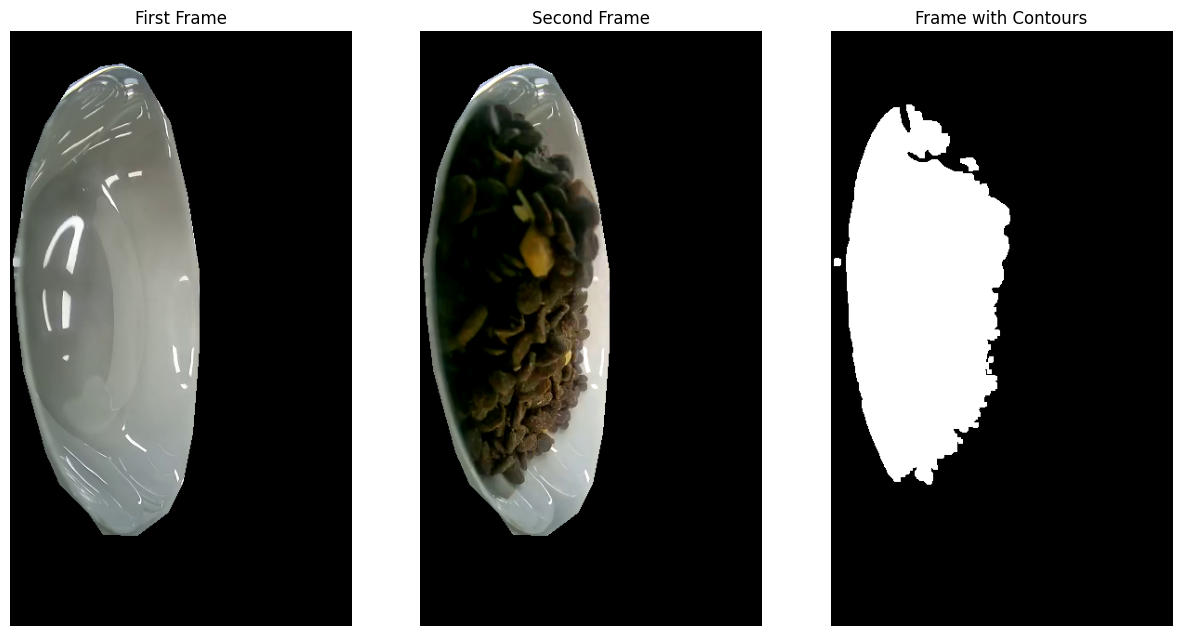

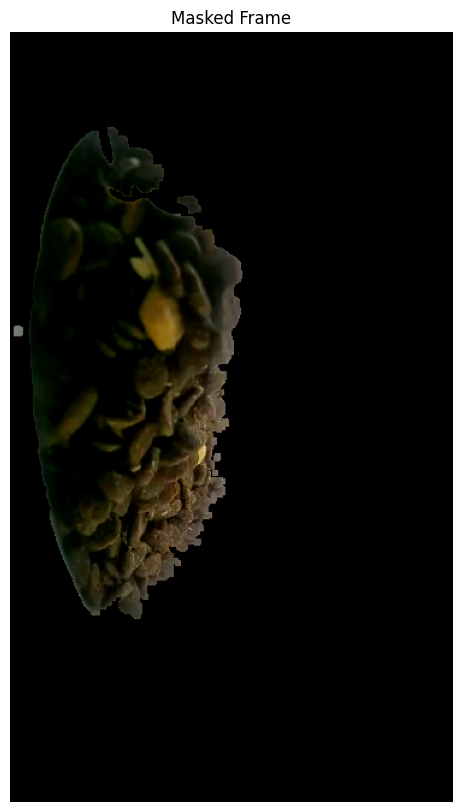

ret: 22265934.549856663
label: 2 (235520, 1)
center: [[9.6798759e+01 8.1980110e+01 5.2619865e+01]
 [4.3779358e+01 3.9149078e+01 1.4224229e+01]
 [5.1621646e-01 8.5524946e-01 4.8945043e-02]]
colors: [(96, 81, 52), (43, 39, 14), (0, 0, 0)]
pet_food_colors: [(96, 81, 52), (43, 39, 14)]
label: (235520, 1) [[2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]]


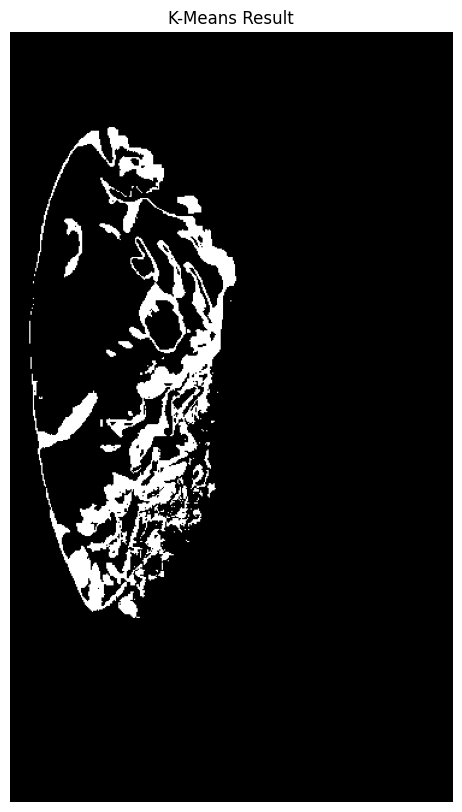

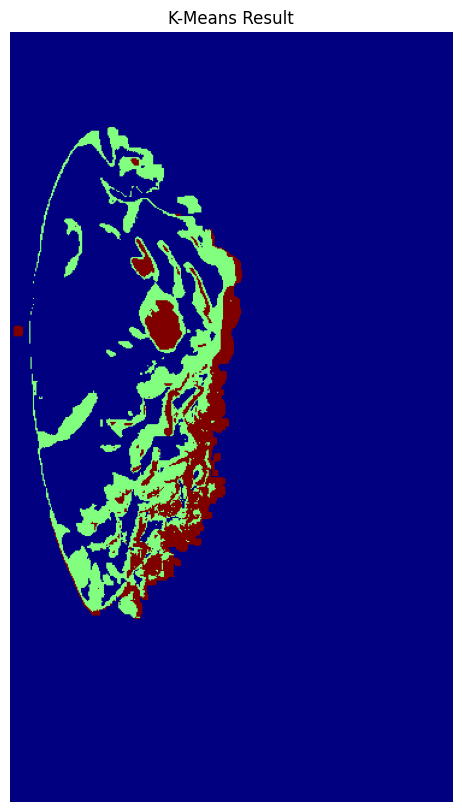

In [44]:
def initialize_centroids(data, k):
    # 从数据集中随机选择k个点作为初始质心
    centers = data[np.random.choice(data.shape[0], k, replace=False)]
    return centers


def get_clusters(data, centroids):
    # 计算数据点与质心之间的距离，并将数据点分配给最近的质心
    distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
    cluster_labels = np.argmin(distances, axis=1)
    return cluster_labels


def update_centroids(data, cluster_labels, k):
    # 计算每个簇的新质心，即簇内数据点的均值
    new_centroids = np.array([data[cluster_labels == i].mean(axis=0) for i in range(k)])
    return new_centroids


def diff_image2(f1, f2):

    frame1 = cv2.cvtColor(f1.copy(), cv2.COLOR_BGR2GRAY)
    frame2 = cv2.cvtColor(f2.copy(), cv2.COLOR_BGR2GRAY)
    
    frame3 = cv2.absdiff(frame1, frame2)

    _, thresh = cv2.threshold(frame3, 60, 255, cv2.THRESH_BINARY)

    # 可选：应用形态学操作以减少噪声
    kernel = np.ones((5, 5), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    # 查找轮廓
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 找到最大连通域
    # 找前十个最大连通域
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

    # 将前十个连通域转换成mask
    mask = np.zeros(frame1.shape, np.uint8)
    for contour in contours:
        cv2.drawContours(mask, [contour], 0, 255, -1)
    # max_contour = max(contours, key=cv2.contourArea)

    # # 将最大连通域转换程mask
    # mask = np.zeros(frame1.shape, np.uint8)
    # cv2.drawContours(mask, [max_contour], 0, 255, -1)

    # 显示原始帧和带有轮廓的帧
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 3, 1)
    plt.title('First Frame')
    plt.imshow(f1)
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(f2)
    plt.axis('off')
    plt.title('Second Frame')
    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.title('Frame with Contours')
    plt.show()


    # 使用mask将第二帧抠出来
    masked_frame = cv2.bitwise_and(f2, f2, mask=mask)
    # 显示抠出来的帧
    plt.figure(figsize=(10, 10))
    plt.imshow(masked_frame)
    plt.axis('off')
    plt.title('Masked Frame')
    plt.show()


    # # 使用kmeans算法聚类, 忽略0的像素值
    # masked_frame[masked_frame == 0] = 255
    # plt.imshow(masked_frame)
    # plt.title('masked_frame')
    # plt.show()

    Z = masked_frame.reshape((-1, 3))
    Z = np.float32(Z)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 3
    ret, label, center = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    # 解释kmeans的输出
    print('ret:', ret)
    print('label:', np.max(label), label.shape)
    print('center:', center)

    # 打印center的颜色
    colors = []
    for i in range(K):
        colors.append((int(center[i][0]), int(center[i][1]), int(center[i][2])))
    print('colors:', colors)

    # 挑选Blue通道是三个通道中最小的颜色
    pet_food_colors = []
    for color in colors:
        if color[2] < color[0] and color[2] < color[1]:
            pet_food_colors.append(color)
    print('pet_food_colors:', pet_food_colors)

    # 显示每个像素的聚类结果
    print('label:', label.shape, label[:10,:])
    result = label.reshape((masked_frame.shape[:2]))

    label1 = result.copy()
    label1[np.where(label1 != 1)] = 0
    label1[np.where(label1 == 1)] = 255
    plt.figure(figsize=(10, 10))
    plt.imshow(label1, cmap='gray')
    plt.axis('off')
    plt.title('K-Means Result')
    plt.show()

    # colormap
    result = result.astype(np.float32)
    result = result / np.max(result) * 255
    result = cv2.applyColorMap(result.astype(np.uint8), cv2.COLORMAP_JET)
    plt.figure(figsize=(10, 10))
    plt.imshow(result)
    plt.axis('off')
    plt.title('K-Means Result')
    plt.show()



diff_image(frame1, frame2)

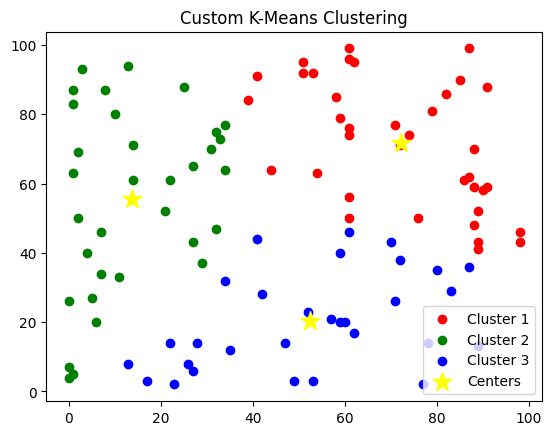

In [45]:
import numpy as np
import matplotlib.pyplot as plt

def kmeans(data, K, max_iters=100, tol=1e-4):
    """
    自定义 K-Means 实现
    :param data: 输入数据，形状为 (N, D)，N 是数据点数量，D 是数据维度
    :param K: 簇的数量
    :param max_iters: 最大迭代次数
    :param tol: 中心点变化的容忍度，用于提前停止
    :return: labels, centers
    """
    N, D = data.shape

    # 1. 随机初始化中心点
    centers = data[np.random.choice(N, K, replace=False)]

    for _ in range(max_iters):
        # 2. 分配数据点到最近的簇
        distances = np.linalg.norm(data[:, np.newaxis] - centers, axis=2)  # 计算每个点到每个中心的距离
        labels = np.argmin(distances, axis=1)  # 找到最近的簇

        # 3. 更新簇中心
        new_centers = np.array([data[labels == k].mean(axis=0) for k in range(K)])

        # 4. 检查是否收敛
        if np.linalg.norm(new_centers - centers) < tol:
            break

        centers = new_centers

    return labels, centers

# 生成随机数据
np.random.seed(42)
data = np.random.randint(0, 100, (100, 2)).astype(np.float32)
data.shape
# 调用自定义 K-Means
K = 3
labels, centers = kmeans(data, K)

# 可视化结果
colors = ['r', 'g', 'b']
for k in range(K):
    plt.scatter(data[labels == k][:, 0], data[labels == k][:, 1], c=colors[k], label=f'Cluster {k+1}')
plt.scatter(centers[:, 0], centers[:, 1], s=200, c='yellow', marker='*', label='Centers')
plt.legend()
plt.title('Custom K-Means Clustering')
plt.show()

In [ ]:
def diff_image(f1, f2):

    frame1 = cv2.cvtColor(f1.copy(), cv2.COLOR_BGR2GRAY)
    frame2 = cv2.cvtColor(f2.copy(), cv2.COLOR_BGR2GRAY)
    
    frame3 = cv2.absdiff(frame1, frame2)

    _, thresh = cv2.threshold(frame3, 60, 255, cv2.THRESH_BINARY)

    # 可选：应用形态学操作以减少噪声
    kernel = np.ones((5, 5), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    # 查找轮廓
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 找到最大连通域
    max_contour = max(contours, key=cv2.contourArea)

    # 将最大连通域转换程mask
    mask = np.zeros(frame1.shape, np.uint8)
    cv2.drawContours(mask, [max_contour], 0, 255, -1)

    # 使用mask将第二帧抠出来
    masked_frame = cv2.bitwise_and(f2, f2, mask=mask)
    return masked_frame
    